#  Abstractive Summarization of Long Podcast Transcripts with BART using Semantic Self-segmentation
Podcasts are a rapidly growing medium for news, commentary, entertainment, and learning.  Some podcast shows release new episodes on a regular schedule (daily, weekly, etc); others irregularly.  Some podcast shows feature short episodes of 5 minutes or less touching on one or two topics; others may release 3+ hour long episodes touching on a wide range of topics.  Some are structured as news delivery, some as conversations, some as storytelling.

Given a podcast episode, its audio, and transcription, return a short text snippet capturing the most important information in the content. Returned summaries should be grammatical, standalone statement of significantly shorter length than the input episode description.

The user task is to provide a short text summary that the user might read when deciding whether to listen to a podcast. Thus the summary should accurately convey the content of the podcast, and be short enough to quickly read on a smartphone screen. It should also be human-readable.

For further information about the challenge, take a look to Podcasts Track Guidelines:
- [TREC 2020 Podcasts Track](https://trecpodcasts.github.io/participant-instructions-2020.html)

In [87]:
import numpy as np
import os
import pandas as pd
import regex as re
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from difflib import SequenceMatcher
from collections import Counter

import tensorflow as tf
from tensorflow import keras

import pysbd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split

# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

## 1. Dataset preparation

### 1.1 Dataset reading

In [88]:
# dataset_path = os.path.join(os.path.abspath("D:/"), 'podcasts-no-audio-13GB')
dataset_path = os.path.join(os.path.abspath(""), 'podcasts-no-audio-13GB')

metadata_path_train = os.path.join(dataset_path, 'metadata.tsv')
metadata_train = pd.read_csv(metadata_path_train, sep='\t')
print("Columns: ", metadata_train.columns)
print("Shape: ", metadata_train.shape)

Columns:  Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix'],
      dtype='object')
Shape:  (105360, 12)


In [89]:
def get_path(episode):
    """
    Get the path of the episode json file
    
    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file

    Returns
    -------
    path : str
        The absolute path of the episode json file
    """
    # extract the 2 reference number/letter to access the episode transcript
    show_filename = episode['show_filename_prefix']
    episode_filename = episode['episode_filename_prefix'] + ".json"
    dir_1, dir_2 = re.match(r'show_(\d)(\w).*', show_filename).groups()

    # check if the transcript file in all the derived subfolders exist
    transcipt_path = os.path.join(dataset_path, "spotify-podcasts-2020",
                                "podcasts-transcripts", dir_1, dir_2,
                                show_filename, episode_filename)
    return transcipt_path

def get_transcription(episode):
    """
    Extract the transcript from the episode json file
    
    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    
    Returns
    -------
    transcript : str
        The transcript of the episode
    """
    with open(get_path(episode), 'r') as f:
        episode_json = json.load(f)
        # seems that the last result in each trastcript is a repetition of the first one, so we ignore it
        transcripts = [
            result["alternatives"][0]['transcript'] if 'transcript' in result["alternatives"][0] else ""
            for result in episode_json["results"][:-1]
        ]
        return " ".join(transcripts)

### 1.2 Dataset analysis

Statistics about episode duration:
count    105360.000000
mean         33.845715
std          22.735674
min           0.175317
25%          13.552638
50%          31.643375
75%          50.446825
max         304.953900
Name: duration, dtype: float64


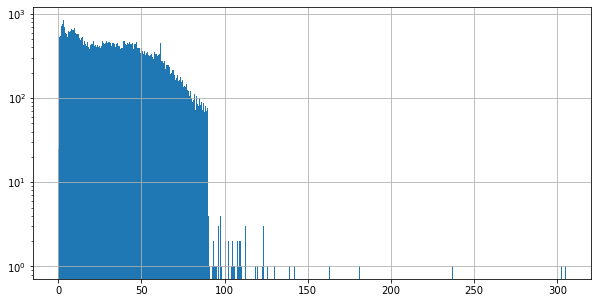

In [6]:
print("Statistics about episode duration:\n"
      f"{metadata_train['duration'].describe()}")
metadata_train['duration'].hist(bins=1000, figsize=(10,5), log=True)
plt.show()

Statistics about number of episodes per show:
count    18376.000000
mean         5.733566
std         19.310585
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1072.000000
dtype: float64


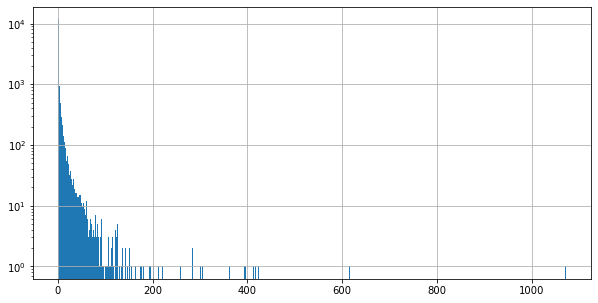

In [5]:
show_episodes = metadata_train.groupby(['show_filename_prefix']).apply(lambda x: list(zip(x['episode_filename_prefix'], x['episode_description']))).to_dict()
show_n_episodes = {k: len(v) for k, v in show_episodes.items()}
print("Statistics about number of episodes per show:\n"
      f"{pd.Series(show_n_episodes.values()).describe()}")
pd.Series(show_n_episodes.values()).hist(bins=1000, figsize=(10,5), log=True)
plt.show()

### 1.3 Dataset cleaning
We filtered the descriptions to establish a subset that is more appropriate as a ground truth set compared to full set of descriptions.


First of all, some of the episodes contain a `NaN` value in the `episode_description` and `show_description` columns. Let's remove them.

In [90]:
print("Before dropping NaN values: \n", metadata_train.isna().any())
metadata_train.dropna(subset=['episode_description', 'show_description'], inplace=True)
print("\nAfter dropping NaN values:\n", metadata_train.isna().any())

Before dropping NaN values: 
 show_uri                   False
show_name                  False
show_description            True
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description         True
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool

After dropping NaN values:
 show_uri                   False
show_name                  False
show_description           False
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description        False
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool


It is also available a *gold dataset* of 150 episodes composed by 6 set of summaries for each episode (900 document-summary-grade triplets) that were graded on the Bad/Fair/Good/Excellent scale (0-3).
Before starting the cleaning process, we merged this gold dataset with the dataset we are going to clean, and the best summary of each episode will be considered.

In [91]:
metadata_path_gold = os.path.join(dataset_path, '150gold.tsv')
metadata_gold = pd.read_csv(metadata_path_gold, sep='\t')

quality = {
    'B': 1,
    'F': 2,
    'G': 3,
    'E': 4
}

# convert egfb columns to a quality score
egfb_columns = ['EGFB', 'EGFB.1', 'EGFB.2', 'EGFB.3', 'EGFB.4', 'EGFB.5']
egfb_to_quality = metadata_gold[egfb_columns].applymap(lambda x: quality[x])

# remove rows with no quality > 1
egfb_to_quality = egfb_to_quality[[any(row > 1) for row in egfb_to_quality.values]] 

# select the best transcript for each episode
best_egfb = egfb_to_quality.apply(lambda x: x.idxmax(), axis=1)
best_summary = [metadata_gold.iloc[i, np.argwhere(metadata_gold.columns == egfb)[0][0] - 1] for i, egfb in best_egfb.iteritems()]

metadata_gold = metadata_gold.loc[best_egfb.index]
metadata_gold['best_summary'] = best_summary

# create a dictionary of the best summary for each episode
gold_summaries = {row['episode id']: row['best_summary'] for i, row in metadata_gold.iterrows()}


In [92]:
# substitute the episode descriptions correspondent to the episodes in the gold set with the best summary
for i, row in metadata_train.iterrows():
    if row['episode_uri'] in gold_summaries.keys():
        metadata_train.at[i, 'episode_description'] = gold_summaries[row['episode_uri']]

We strive to enhance the quality of creator descriptions using heuristics. In order to do that, the following cleaning steps are preformed:
- remove sentences that contain URLs, email addresses in the episode descriptions
- remove tokens corresponding to @mentions, #hashtags and emojii
- removing the content after `"---"` that usually is a sponsorship or a boilerplate (e.g., “--- This episode is sponsored by ...” “--- Send in a voice message”)
- identify sentences that contain not useful content and remove them from the descriptions. In order to do that, we compute a *salience score* for each sentence of the description by summing over word IDF scores. Then we remove sentences if their salience scores are lower than a threshold. 


In [10]:
def compute_document_frequencies(descriptions):
    """
    Compute the document frequencies in the whole dataset descriptions

    Parameters
    ----------
    descriptions : list of str
        The descriptions of the episodes
    
    Returns
    -------
    A dictionary of word frequencies
    """
    seg = pysbd.Segmenter(language="en", clean=False)

    # get a set of words contained in each description (words are all lowercase)
    flattened_descriptions = []
    for description in tqdm(descriptions, desc="Computing word frequencies"):
        description_set = set()
        for sentence in seg.segment(description):
            description_set.update([word.lower() for word in word_tokenize(sentence)])
        flattened_descriptions.extend(list(description_set))
            
    counts = pd.Series(Counter(flattened_descriptions))  # Get counts and transform to Series
    return counts

# compute the document frequencies that will be used to compute the sentence salience score
document_frequencies = compute_document_frequencies(metadata_train['episode_description'])

Computing word frequencies: 100%|██████████| 105153/105153 [07:58<00:00, 219.77it/s]


In [93]:
# store the old dataframe to make comparisons
metadata_train_old = metadata_train.copy()

In [94]:
def remove_boilerplate(description):
    """
    Remove boilerplate from the episode description

    Parameters
    ----------
    description : str
        The episode description

    Returns
    -------
    A description without boilerplate (str)
    """
    boilerplate_re = re.compile(r"---.*")
    return boilerplate_re.sub("", description)

def remove_link_or_sponsors(description):
    """
    Remove sentences containing links and sponsors or username and hashtag from the episode description

    Parameters
    ----------
    description : str
        The episode description

    Returns
    -------
    A description without links and sponsors (str)
    """
    username_and_hashtag_re = re.compile(r"(\B@\w+|\B#\w+)")
    links_or_sponsors_re = re.compile(
        r"(http|https|[pP]atreon|[eE]mail|[dD]onate|IG|[iI]nstagram|[fF]acebook|[yY]outube|[tT]witter|[dD]iscord|[fF]ollow|www|\.com|\*|[sS]potify)"
    )

    # remove username and hashtag
    description = username_and_hashtag_re.sub(" ", description)

    # remove sentences containing links and sponsors
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(description)
    sentences = [sentence for sentence in sentences if not links_or_sponsors_re.search(sentence)] 
    return " ".join(sentences)

def remove_emojii(description):
    """
    Remove emojii from the episode description

    Parameters
    ----------
    description : str
        The episode description

    Returns
    -------
    A description without emojii (str)
    """
    emoji_re = re.compile(r"[^\x00-\x7F]+")
    return emoji_re.sub(" ", description)

print("\nRemoving boilerplate from the episode descriptions:")
metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(remove_boilerplate)

print("Removing links and sponsors from the episode descriptions:")
metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(remove_link_or_sponsors)

print("Removing emojii from the episode descriptions:")
metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(remove_emojii)


Removing boilerplate from the episode descriptions:


100%|██████████| 105153/105153 [00:00<00:00, 120642.24it/s]


Removing links and sponsors from the episode descriptions:


100%|██████████| 105153/105153 [06:19<00:00, 276.95it/s]


Removing emojii from the episode descriptions:


100%|██████████| 105153/105153 [00:00<00:00, 124739.31it/s]


In [79]:
# see a few examples of comparisons between the old and new descriptions
samples = [137, 172]
print("\nExamples of comparisons before and after removing sponsors and links:")
for i in samples:
        print("BEFORE:" 
                f"\n\t- {metadata_train_old['episode_description'].iloc[i]}")
        print("AFTER:"
                f"\n\t- {metadata_train['episode_description'].iloc[i]}")
        print("\n")


Examples of comparisons before and after removing sponsors and links:
BEFORE:
	- If you like ASMR you will love this White Noise Machine on Amazon! Tap here to check it out! If you enjoyed this make sure to give us a 5 star rating!  ---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app  Support this podcast: https://anchor.fm/AdamDino/support
AFTER:
	- If you like ASMR you will love this White Noise Machine on Amazon!  Tap here to check it out!  If you enjoyed this make sure to give us a 5 star rating!  


BEFORE:
	- Danielle and Jessi could talk your ears off when it comes to this topic. Episode 004 is all about their skincare routines, products they love, and tips and tricks for feeling radiant and confident in your own skin. Follow them @basicallyorganicpodcast (and @jessimechler @itsdaniellebridges) for tags of all the brands they’re currently loving! Rate and subscribe!!   ---   Support this podcast: https://anchor.fm/basicallyorg

In [95]:
def sentence_salience_score(sentence, num_descriptions, document_frequencies):
    """
    Compute the salience score of a sentence by summing over word IDF scores.
    Only alphabetic words that are longer that one character and are neither stop words nor words like 'episode' or 'podcast'
    are considered when computing sentence salience scores.

    Parameters
    ----------
    sentence : str
        The sentence to compute the salience score for
    num_descriptions : int
        The number of descriptions in the dataset
    document_frequencies : pandas.Series
        The document frequencies in the whole dataset descriptions
    
    Returns
    -------
    The salience score of the sentence (float)
    """
    idf_scores = []
    tokenized_sentence = word_tokenize(sentence)

    # compute IDF scores for each word in the sentence and sum them up 
    
    for word in tokenized_sentence:
        lower_world = word.lower()
        # consider only alphabetic words, and remove stop words, single character
        if lower_world in document_frequencies.keys() and lower_world.isalpha() and lower_world not in stopwords.words('english') and len(lower_world) > 1 and lower_world not in ['episode', 'podcast']:
            # get document frequency
            df = document_frequencies[lower_world]

            # compute idf score
            idf_score = np.log(num_descriptions/df)
            idf_scores.append(idf_score)

    idf_scores = np.array(idf_scores) 
    salience_score = idf_scores.mean() if len(idf_scores)>0 else 0.0
    return salience_score

def remove_unuseful_sentences(description, num_descriptions, word_frequencies, threshold=3.6):
    """
    Remove sentences that are not useful for the transcriptions

    Parameters
    ----------
    description : str
        The episode description
    num_descriptions : int
        The number of descriptions in the dataset
    word_frequencies : pandas.Series
        The word frequencies in the whole dataset descriptions
    threshold : double
        The threshold for the salience score of a sentence to be considered useful

    Returns
    -------
    A description without unuseful sentences (str)
    """
    # segment the text into sentences
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(description)
    # remove sentences that are not useful for the transcriptions
    sentences = [sentence for sentence in sentences if sentence_salience_score(sentence, num_descriptions, word_frequencies) > threshold]
    return " ".join(sentences)

metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(lambda x: remove_unuseful_sentences(x, metadata_train.shape[0], document_frequencies))

100%|██████████| 105153/105153 [24:23<00:00, 71.84it/s] 


In [96]:
# see a few examples of comparisons between the old and new descriptions
samples = [137, 172]
print("\nExamples of comparisons before and after removing unuseful sentences:")
for i in samples:
        print("BEFORE:" 
                f"\n\t- {metadata_train_old['episode_description'].iloc[i]}")
        print("AFTER:"
                f"\n\t- {metadata_train['episode_description'].iloc[i]}")
        print("\n")


Examples of comparisons before and after removing sponsors and links:
BEFORE:
	- If you like ASMR you will love this White Noise Machine on Amazon! Tap here to check it out! If you enjoyed this make sure to give us a 5 star rating!  ---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app  Support this podcast: https://anchor.fm/AdamDino/support
AFTER:
	- If you like ASMR you will love this White Noise Machine on Amazon!   Tap here to check it out!  


BEFORE:
	- Danielle and Jessi could talk your ears off when it comes to this topic. Episode 004 is all about their skincare routines, products they love, and tips and tricks for feeling radiant and confident in your own skin. Follow them @basicallyorganicpodcast (and @jessimechler @itsdaniellebridges) for tags of all the brands they’re currently loving! Rate and subscribe!!   ---   Support this podcast: https://anchor.fm/basicallyorganicpodcast/support
AFTER:
	- Danielle and Jessi could tal

In order to select a subset of the corpus that is suitable for training supervised models, we filtered the descriptions using three heuristics shown in the table below. These filters overlap to some extent, and remove about a third of the entire set. The remaining episodes we call the **Brass Set**.

| Criterion                        | Threshold                                                    |
| -------------------------------- | ------------------------------------------------------------ |
| Length                           | descriptions that are very long (> 750 characters) or short (< 20 characters). |
| Similarity to show description   | descriptions with high lexical overlap (over 50%) with their show description. |
| Similarity to other descriptions | descriptions with high lexical overlap (over 60%) with other episode descriptions in the same show. |


In [112]:
def check_lenght_brass(episode, upper_bound=750, lower_bound=20):
    """
    Check if the episode descriptions is not too long (> 750 characters) or not too short (< 20 characters)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    upper_bound : int
        The upper bound of the episode description length
    lower_bound : int
        The lower bound of the episode description length
    
    Returns
    -------
    Boolean indicating if the episode description is long enough
    """
    return len(episode['episode_description']) <= upper_bound and len(episode['episode_description']) >= lower_bound
    
def description_similarity(a, b):
    """
    Measure the overlapping between two descriptions

    Parameters
    ----------
    a : str
        The first description
    b : str
        The second description
    
    Returns
    -------
    Value indicating the overlapping between the two descriptions
    """
    return SequenceMatcher(None, a, b).ratio()

def check_show_description_overlap_brass(episode, thresh=0.5):
    """
    Check if the episode descriptions overlapping with the show description is not too high (< 0.5)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    thresh : float
        The threshold of the overlap between the episode description and the show description

    Returns
    -------
    Boolean indicating if the episode description is different enough from the show description
    """
    return description_similarity(episode['show_description'], episode['episode_description']) < thresh
    
def check_other_description_overlap_brass(episode, show_episodes, thresh=0.6):
    """
    Check if the episode descriptions overlapping with the other description in the same show is not too high (< 0.6)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    show_episodes : dict
        A dictionary of the episodes of the same show
    thresh : float
        The threshold of the overlap between the episode description and the other description
    
    Returns
    -------
    Boolean indicating if the episode description is different enough from the other description
    """
    for other_prefix, other_description in show_episodes[episode['show_filename_prefix']]:
        if other_prefix != episode['episode_filename_prefix'] and description_similarity(episode['episode_description'], other_description) > thresh and len(episode['episode_description']) < len(other_description):
            return False
    return True


brass_set_lenght = metadata_train[metadata_train.progress_apply(check_lenght_brass, axis=1)]
print(f"Removed {len(metadata_train) - len(brass_set_lenght)} episodes ({(100-(len(brass_set_lenght)/len(metadata_train)*100)):.2f}%) because of too long or too short descriptions")

brass_set_show_overlap = brass_set_lenght[brass_set_lenght.progress_apply(check_show_description_overlap_brass, axis=1)]
print(f"Removed {len(brass_set_lenght) - len(brass_set_show_overlap)} episodes ({(100-(len(brass_set_show_overlap)/len(brass_set_lenght)*100)):.2f}%) because of too high overlap with the show description")

show_episodes = brass_set_show_overlap.groupby(['show_filename_prefix']).apply(lambda x: list(zip(x['episode_filename_prefix'], x['episode_description']))).to_dict()
brass_set = brass_set_show_overlap[brass_set_show_overlap.progress_apply(lambda x: check_other_description_overlap_brass(x, show_episodes), axis=1)]
print(f"Removed {len(brass_set_show_overlap) - len(brass_set)} episodes ({(100-(len(brass_set)/len(brass_set_show_overlap)*100)):.2f}%) because of too high overlap with other descriptions in the same show")

100%|██████████| 105153/105153 [00:01<00:00, 77508.03it/s]


Removed 17108 episodes (16.27%) because of too long or too short descriptions


100%|██████████| 88045/88045 [01:16<00:00, 1157.95it/s]


Removed 1597 episodes (1.81%) because of too high overlap with the show description


100%|██████████| 86448/86448 [41:22<00:00, 34.82it/s]  

Removed 9033 episodes (10.45%) because of too high overlap with other descriptions in the same show


In [128]:
# look to the removed episode descriptions due to the overlap with the show description
removed_episodes_show_overlap = pd.concat([brass_set_lenght, brass_set_show_overlap]).drop_duplicates(keep=False)[['show_description', 'episode_description']]
removed_episodes_show_overlap['overlapping'] = removed_episodes_show_overlap.apply(lambda row: description_similarity(row['show_description'], row['episode_description']), axis=1)

num_to_visualize = 3

for _ in range(num_to_visualize):
    row = removed_episodes_show_overlap.sample()
    print(f"Episode description: \n\t{row['episode_description'].values[0]}")
    print(f"Show description: \n\t{row['show_description'].values[0]}")
    print(f"Overlapping score: \n\t{row['overlapping'].values[0]}")
    print("\n")

Episode description: 
	Life and fashion all packed into a panini 
Show description: 
	Life and fashion all packed into a panini
Overlapping score: 
	0.9879518072289156


Episode description: 
	Today, three of the worlds straightest males have gathered to talk about the straightest things. 
Show description: 
	On the Wearings-Socks Podcast, three of the worlds straightest males have gathered to talk about the straightest things.
Overlapping score: 
	0.8663594470046083


Episode description: 
	We look back at the case of the Maryland Court vs Adnan Syed and tell you what we think really happened on that fateful day in 1999 
Show description: 
	We're out here doing a podcast about the Serial Podcast that is based off of the State of Maryland v. Adnan Syed case that happened back in 1999.
Overlapping score: 
	0.51985559566787




In [165]:
# look to the removed episode descriptions due to the overlap with the other episode descriptions in the same show
removed_episodes_other_overlap = pd.concat([brass_set, brass_set_show_overlap]).drop_duplicates(keep=False)[['show_filename_prefix', 'episode_filename_prefix', 'episode_description']]
two_episodes_show  = {str(show_filename_prefix): show_episodes[show_filename_prefix] for show_filename_prefix in removed_episodes_other_overlap['show_filename_prefix'] if len(show_episodes[show_filename_prefix]) == 2 }
removed_episodes_other_overlap = removed_episodes_other_overlap[removed_episodes_other_overlap['show_filename_prefix'].isin(two_episodes_show.keys())]
other_episode_show = {}
for i, row in removed_episodes_other_overlap.iterrows():
    if row['show_filename_prefix'] in two_episodes_show:
        if row['episode_filename_prefix'] in two_episodes_show[row['show_filename_prefix']][0]:
            other_episode_show[row['show_filename_prefix']] = two_episodes_show[row['show_filename_prefix']][1][1]
        else:
            other_episode_show[row['show_filename_prefix']] = two_episodes_show[row['show_filename_prefix']][0][1]
removed_episodes_other_overlap['other_episode_description'] = removed_episodes_other_overlap.apply(lambda row: other_episode_show[row['show_filename_prefix']], axis=1)
removed_episodes_other_overlap['overlapping'] = removed_episodes_other_overlap.apply(lambda row: description_similarity(row['episode_description'], row['other_episode_description']), axis=1)

num_to_visualize = 3

for _ in range(num_to_visualize):
    row = removed_episodes_other_overlap.sample()
    print(f"Episode description: \n\t{row['episode_description'].values[0]}")
    print(f"Other episode description: \n\t{row['other_episode_description'].values[0]}")
    print(f"Overlapping score: \n\t{row['overlapping'].values[0]}")
    print("\n")

Episode description: 
	A real banger, one for the ages  
Other episode description: 
	This is a banger, one for the ages  
Overlapping score: 
	0.8405797101449275


Episode description: 
	In this exercise, drift off to sleep while listening to nature sounds. 
Other episode description: 
	In the full version of this exercise, focus on muscle relaxation while listening to nature sounds. 
Overlapping score: 
	0.7176470588235294


Episode description: 
	In this episode, Shawna and Larry talk with Jason Lobmeyer about helpful tips on how to be a great CCV kids coach. 
Other episode description: 
	In this episode, Shawna and Larry talk with George Mang about helpful tips on how deal with behavioral issues in a kids experience. 
Overlapping score: 
	0.7125506072874493




#### 1.3.1 Further cleaning of the data
The podcast episodes should be restricted to the English language, but they cover a range of geographical regions and we found a number of non-English podcasts in the dataset. So we remove them.

In [219]:
try:
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('words')
wordset = set(words.words())

def is_english(text, threshold = 0.3):
    """
    Check if the text is written in english

    Parameters
    ----------
    text : str
        The text to check
    threshold : float
        The threshold of the ratio of english words in the text
    
    Returns
    -------
    Boolean indicating if the text is written in english
    """
    tokenized = word_tokenize(text)
    alpha_tokenized = [word.lower() for word in tokenized if word.isalpha()]
    dictionary_score = sum([word.lower() in wordset for word in alpha_tokenized
                           ]) / len(alpha_tokenized)
    return dictionary_score > threshold

# remove episodes with non english description
len_old_brass_set = len(brass_set)
brass_set = brass_set[brass_set.progress_apply(lambda x: is_english(x['episode_description']), axis=1)]
print(f"Removed {len_old_brass_set - len(brass_set)} episodes ({(100-(len(brass_set)/len_old_brass_set*100)):.2f}%) because of non english description")

100%|██████████| 77415/77415 [00:26<00:00, 2925.98it/s]

Removed 374 episodes (0.48%) because of non english description


In [220]:
# store brass set
brass_set.to_csv(os.path.join(os.path.dirname(metadata_path_train), "brass_set.tsv"), index=False, sep='\t')

In [221]:
# load brass set
brass_set = pd.read_csv(os.path.join(dataset_path, "brass_set.tsv"), sep='\t')

### 1.5 Semantic segmentation

### 1.6  Chunck classifier

In [9]:
def look_ahead_chuck(sentences, lower_chunk_size):
    """
    Look-ahead function to determine the next chunk
    """
    if sum([len(s) for s in sentences]) < lower_chunk_size:
        # if the remaining sentences size is smaller than the lower bound, we return the remaining sentences
        return sentences
    else:
        # next chunk size should be at least the lower bound 
        for i in range(len(sentences)):
            if sum([len(s) for s in sentences[:i+1]]) >= lower_chunk_size:
                return sentences[:i+1]


def semantic_segmentation(text, model, lower_chunk_size=300, upper_chunk_size=2000):
    """
    Algorithm proposed by Moro et. al. (2022) to semantically segment long inputs into GPU memory-adaptable chunks.
    https://www.aaai.org/AAAI22Papers/AAAI-3882.MoroG.pdf

    Parameters
    -------------
    text: str
        The text to be segmented
    model: SentenceTransformer
        The model to be used for the sentence embeddings
    lower_chunk_size: int
        The lower bound of the chunk size
    upper_chunk_size: int
        The upper bound of the chunk size
    Return
    -------
    List of chunks of text
    """

    # segment the text into sentences
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(text)

    chuncks = []
    current_chunk = [sentences[0]]

    # Iterate over the sentences in the text
    for i, sentence in enumerate(sentences[1:]):
        if sentence == sentences[-1]:
            # If the sentence is the last one, we add it to the last chunk
            current_chunk.append(sentence)
            chuncks.append(current_chunk)
        elif sum([len(s) for s in current_chunk]) + len(sentence) < lower_chunk_size:
            # standardize each chunk to a minimum size to best leverage the capability of Transformers
            current_chunk.append(sentence)
        elif sum([len(s) for s in current_chunk]) + len(sentence) > upper_chunk_size:
            # if the chunk is too big, we add it to the list of chunks and start a new one
            chuncks.append(current_chunk)
            current_chunk = [sentence]
        else:
            idx = i+1
            next_chuck = look_ahead_chuck(sentences[idx+1:], lower_chunk_size)
            
            # get the embedding of the previous chunk and the next chunk
            current_embedding = model.encode(current_chunk)
            next_embedding = model.encode(next_chuck)
            sentence_embedding = model.encode([sentence])

            # get the cosine similarity between the embedding of the embeddings
            score_current_chunk = util.cos_sim(sentence_embedding, current_embedding).numpy().mean()
            score_next_chunk = util.cos_sim(sentence_embedding, next_embedding).numpy().mean()

            # if the score_current_chunk is higher than the score_next_chunk, we add the sentence to the current chunk
            if score_current_chunk > score_next_chunk:
                current_chunk.append(sentence)
            else:
                if sum([len(s) for s in current_chunk]) >= lower_chunk_size:
                    chuncks.append(current_chunk)
                    current_chunk = [sentence]
                else:
                    current_chunk.append(sentence)
    return chuncks

# Initialize the sentence transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")
semantic_segmentation(get_transcription(metadata_train.iloc[105325]), model)

[["Hi, I'm Ben Folds. ",
  "Welcome to a new podcast series that I'm hosting called Arts vote 2020 where I talked to presidential candidates about arts and politics this year. ",
  'I joined the board of the Americans for the Arts action fund to help artists enthusiasts like you and made a better understand where these candidates stand on the issues. ',
  'We care about former US senator and Anchorage mayor Mark begich is joining me to moderate this series as we talked to candidates about Impact of the arts and arts education our communities schools and our lives.  ',
  'I wanted to do this podcast series because I realized that if the Arts Community wants to move the needle on the future support of the Arts. ',
  'Then we need to act now to engage candidates on these issues. ',
  'Our first interviews will be with 20/20 presidential candidates. ',
  'Mayor Pete Buddha judge and congressman John Delaney. ',
  "We're going to try our best to interview everyone running for president to l

### 1.7 Chunk Selection

From each chunk an encoding of each sentence is extracted using a pretrained RoBerta Transformerss to obtain a dense encoding. The encoding of the chunk is the mean of the encoding of its sentences.

In [10]:
class FeatureExtractor:
    
    def __init__(self):
        self.model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    def extract_features(self,text):
        """
        Extract features from text using a mean of the tf-idf
        Parameters:
            - text: string representing a document
        Returns:
            - extracted features
        """
        embeddings = []
        for sentence in text:
          embeddings.append(self.model.encode(sentence))

        features = np.mean(embeddings, axis=0)

        return features

In order to keep only useful chunks for each transcript we compare the chunk with the corresponding summary of the transcript it belongs to and, if the score obtained with a certain metric is below a threshold (strictly coupled with the metric), the chunk is not taken into account as a part of the transcript.

In [19]:
def isChunkUseful(chunk, summary, metric, threshold):
    """
    Parameters:
        - chunk: part of the transcript
        - summary: summary of a transcript
        - metric: function of ariety 2 (chunk, summary) used to evaluate the summary
        - threshold: value used to decide whether chunk is a good summary or not
    Returns:
        - True if the chunk is a good summary, False otherwise
    """
    score = metric(chunk, summary)
    if score < threshold:
        result = False
    else:
        result = True
    
    return result

The chosen metric is BERTscore f1-score because it is a semantic metric, i.e. it takes into account the meaning of words in the sentences.

In [7]:
def bertscore_f1_score(reference, candidate):
    """
    BERTScore score, see https://github.com/huggingface/datasets/tree/master/metrics/bertscore for API
    Parameters:
        reference: reference translation
        candidate: generated translation
    Returns:
        BERTScore f1 score
    """
    bertscore = load_metric("bertscore")
    result = bertscore.compute(
        predictions=[candidate],
        references=[reference],
        lang="en",
        rescale_with_baseline=True
    )
    return result['f1'][0]

The golden set is used for the training and the test of the CatBooster classifier

In [ ]:
# creation of gold set

metadata_path_gold = os.path.join(dataset_path, '150gold.tsv')
metadata_gold = pd.read_csv(metadata_path_gold, sep='\t')
metadata_gold = pd.merge(metadata_gold, metadata_train, left_on='episode id', right_on='episode_uri')

quality = {
    'B': 1,
    'F': 2,
    'G': 3,
    'E': 4
}

# convert egfb columns to a quality score
egfb_columns = ['EGFB', 'EGFB.1', 'EGFB.2', 'EGFB.3', 'EGFB.4', 'EGFB.5']
egfb_to_quality = metadata_gold[egfb_columns].applymap(lambda x: quality[x])

# remove rows with no quality > 1
egfb_to_quality = egfb_to_quality[[any(row > 1) for row in egfb_to_quality.values]] 

# select the best transcript for each episode
best_egfb = egfb_to_quality.apply(lambda x: x.idxmax(), axis=1)
best_summary = [metadata_gold.iloc[i, np.argwhere(metadata_gold.columns == egfb)[0][0] - 1] for i, egfb in best_egfb.iteritems()]

metadata_gold = metadata_gold.loc[best_egfb.index]
metadata_gold['best_summary'] = best_summary

# add transcripts
metadata_gold['transcript'] = metadata_gold.apply(get_transcription, axis=1)

data = metadata_gold[['episode id', 'transcript', 'best_summary']]
num_episodes = data.size


In [20]:
threshold = 0.5
metric = bertscore_f1_score

# creation of the dataset for chunk classification
# creation of the targets

targets = []

for i in range(num_episodes):
    print(f"Episode: {i+1}")
    chunks = semantic_segmentation(data.transcript[i], model)
    description = data.best_summary[i]
    num_chunks = len(chunks)
    print(f"Num chunks: {num_chunks}")
    for j in range(num_chunks):
        print(f"Chunk {j+1}")
        if isChunkUseful(' '.join(chunks[j]), description, metric, threshold):
            targets.append(1)
        else:
            targets.append(0)

y = np.array(targets)

Episode: 1


KeyboardInterrupt: 

In [ ]:
# extraction of the features

extractor = FeatureExtractor()
features = []
for i in len(num_episodes):
    chunks = semantic_segmentation(data.transcript[i], model)
    for j in range(len(chunks)):
        chunk = chunks[j]
        features.append(extractor.extract_features(chunk))

X = np.array(features)


In [ ]:
dataset = np.hstack((X,y))
df_chunk = pd.DataFrame(dataset)
df_chunk.to_csv("chunks.csv",header=False,index=False)

In [ ]:
# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# training the model
catboost = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2)
# Fit model
catboost.fit(X_train, y_train)

# Test the model
y_pred = catboost.predict(X_test)
accuracy = accuracy(y, y_pred)

print(f"Accuracy of chunk selection: {round(accuracy,2)}")


## 2. Training

In [ ]:
max_input_length = 1024
max_target_length = 256

train_dataset = Dataset.from_pandas(train_data)

model_checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def preprocess_function(dataset, text_column, summary_column, max_input_length, max_target_length, padding, prefix="summarize: "):
    inputs = dataset[text_column]
    targets = dataset[summary_column]
    inputs = [prefix + inp for inp in inputs]
    model_inputs = tokenizer(inputs, max_length=max_input_length, padding=padding, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
padding = "max_length"
train_dataset = train_dataset.map(
                lambda x: preprocess_function(x, "transcript", "best_summary", max_input_length, max_target_length, padding, prefix="summarize: "),
                batched=True,
                remove_columns=train_dataset.column_names,
                desc="Running tokenizer on train dataset"
            )

In [ ]:
from functools import partial

def sample_generator(dataset, model, tokenizer, shuffle, pad_to_multiple_of=None):
    if shuffle:
        sample_ordering = np.random.permutation(len(dataset))
    else:
        sample_ordering = np.arange(len(dataset))
    for sample_idx in sample_ordering:
        example = dataset[int(sample_idx)]
        # Handle dicts with proper padding and conversion to tensor.
        example = tokenizer.pad(example, return_tensors="np", pad_to_multiple_of=pad_to_multiple_of)
        example = {key: tf.convert_to_tensor(arr, dtype_hint=tf.int32) for key, arr in example.items()}
        if model is not None and hasattr(model, "prepare_decoder_input_ids_from_labels"):
            decoder_input_ids = model.prepare_decoder_input_ids_from_labels(
                labels=tf.expand_dims(example["labels"], 0)
            )
            example["decoder_input_ids"] = tf.squeeze(decoder_input_ids, 0)
        yield example, example["labels"]  # TF needs some kind of labels, even if we don't use them
    return

# region Helper functions
def dataset_to_tf(dataset, model, tokenizer, total_batch_size, num_epochs, shuffle):
    if dataset is None:
        return None
    train_generator = partial(sample_generator, dataset, model, tokenizer, shuffle=shuffle)
    train_signature = {
        feature: tf.TensorSpec(shape=(None,), dtype=tf.int32)
        for feature in dataset.features
        if feature != "special_tokens_mask"
    }
    if (
        model is not None
        and "decoder_input_ids" not in train_signature
        and hasattr(model, "prepare_decoder_input_ids_from_labels")
    ):
        train_signature["decoder_input_ids"] = train_signature["labels"]
    # This may need to be changed depending on your particular model or tokenizer!
    padding_values = {
        key: tf.convert_to_tensor(tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0, dtype=tf.int32)
        for key in train_signature.keys()
    }
    padding_values["labels"] = tf.convert_to_tensor(-100, dtype=tf.int32)
    train_signature["labels"] = train_signature["input_ids"]
    train_signature = (train_signature, train_signature["labels"])
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    tf_dataset = (
        tf.data.Dataset.from_generator(train_generator, output_signature=train_signature)
        .with_options(options)
        .padded_batch(
            batch_size=total_batch_size,
            drop_remainder=True,
            padding_values=(padding_values, np.array(-100, dtype=np.int32)),
        )
        .repeat(int(num_epochs))
    )
    return tf_dataset

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
total_train_batch_size = 2
num_train_epochs = 3
learning_rate = 5e-5
tf_train_dataset = dataset_to_tf(
            train_dataset,
            model,
            tokenizer,
            total_batch_size=total_train_batch_size,
            num_epochs=num_train_epochs,
            shuffle=True,
        )

In [ ]:
from transformers import create_optimizer
# region Optimizer, loss and LR scheduling
# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = len(train_dataset) // total_train_batch_size
num_train_steps = num_train_epochs * num_update_steps_per_epoch
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate, num_train_steps=num_train_steps, num_warmup_steps=0
)

def masked_sparse_categorical_crossentropy(y_true, y_pred):
    # We clip the negative labels to 0 to avoid NaNs appearing in the output and
    # fouling up everything that comes afterwards. The loss values corresponding to clipped values
    # will be masked later anyway, but even masked NaNs seem to cause overflows for some reason.
    # 1e6 is chosen as a reasonable upper bound for the number of token indices - in the unlikely
    # event that you have more than 1 million tokens in your vocabulary, consider increasing this value.
    # More pragmatically, consider redesigning your tokenizer.
    losses = tf.keras.losses.sparse_categorical_crossentropy(
        tf.clip_by_value(y_true, 0, int(1e6)), y_pred, from_logits=True
    )
    # Compute the per-sample loss only over the unmasked tokens
    losses = tf.ragged.boolean_mask(losses, y_true != -100)
    losses = tf.reduce_mean(losses, axis=-1)
    return losses

In [ ]:
from datasets import load_metric
# region Metric
metric = load_metric("rouge")
# endregion

# region Training
model.compile(loss={"logits": masked_sparse_categorical_crossentropy}, optimizer=optimizer)

In [ ]:
model.fit(
                tf_train_dataset,
                epochs=int(num_train_epochs),
                steps_per_epoch=num_update_steps_per_epoch,
            )

## 3. Evaluation

transcript_exaple = train_data.iloc[45].transcript
transcript_exaple

In [ ]:
# best summarization
train_data.iloc[45].best_summary

In [ ]:
example = np.reshape(tokenizer(transcript_exaple, max_length=max_input_length, padding=padding, truncation=True).input_ids, (1,-1))

In [ ]:
output =model.generate(example)

In [ ]:
print(tokenizer.decode(output[0], skip_special_tokens=True))